# Final Analysis: Mental Rotation Task Prediction with Multi-Modal Biosignals

## Overview
This notebook consolidates the results from preprocessing, feature engineering, baseline modeling, and multi-modal fusion modeling for predicting outcomes in a Mental Rotation Task using the STD dataset. The dataset includes biosignals from EEG, eye tracking (EYE, IVT), GSR, and facial expressions (TIVA). The pipeline covers data cleaning, feature extraction, imbalance handling, model training, and evaluation, with a focus on achieving robust predictions (target AUC ~0.85+). Visualizations include class balance, feature distributions, model performance, and feature importance.

## Objectives
- Summarize data characteristics and preprocessing steps.
- Present baseline model results (XGBoost).
- Highlight fusion model performance (ensemble with SMOTE/VAE).
- Compare models and modalities.
- Provide visualizations and insights for feature importance and model behavior.
- Conclude with recommendations for deployment and future work.

## Dataset
- Source: STD dataset (multi-modal biosignals).
- Modalities: EEG (brain waves), EYE (pupil, gaze), IVT (fixation, saccades), GSR (skin conductance), TIVA (facial emotions).
- Target: Binary 'Result' (1=Correct, 0=Incorrect).
- Shape: ~1572 rows, 57 features after engineering.

## Note
All the stats, mathematical figures, visualization are directly taken from outputs of following notebooks:

*   01_preprocessing.ipynb
*   02_feature_engineering.ipynb
*   03_modeling_baseline.ipynb
*   04_modeling_fusion.ipynb






In [39]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import joblib
# import shap

# Settings
plt.style.use('default')
sns.set_palette('husl')
np.random.seed(42)

print('✅ Setup complete')


✅ Setup complete


In [51]:
from PIL import Image
from IPython.display import display

# **Section 1: Dataset Processing and Feature Extraction**

**Note:** All dataset processing and feature extraction steps were implemented in `01_preprocessing.ipynb and 02_feature_engineering.ipynb`. This section summarizes how raw multimodal data was converted into a clean, feature-rich format suitable for modeling.


---

## 1️. Data Sources and Modalities

The dataset consists of multi-modal biosignal recordings from 38 participants, covering:

- **PSY (Psychological Data):** Task responses, timing, question metadata.
- **EEG:** Brainwave signals (delta, theta, alpha, beta, gamma bands).
- **GSR:** Galvanic skin response measuring skin conductance.
- **EYE / IVT:** Eye-tracking data including pupil size, fixation counts, saccades, and gaze dispersion.
- **TIVA:** Facial expression emotion scores.

Each participant has several raw CSV files per modality.

---

## 2️. Processing Steps

### General Setup and Helper Functions

- Libraries used: `pandas`, `numpy`, `scipy`, `matplotlib`, `seaborn`.
- Custom helper functions (`safemeanarr`, `safestdarr`) handle NaNs safely.
- Visualization functions were used to plot feature distributions.

### PSY Data Processing

- Loaded PSY files per participant.
- Retained essential columns (`Key`, `Category`, `QuestionNumber`, `Difficulty`, `ResponseTime`, `routineStart`, `routineEnd`, `verdict`).
- Converted time columns to milliseconds.
- Concatenated all participant data and standardized column order.
- Saved cleaned PSY dataframe to CSV for downstream use.

### EEG Feature Extraction

- Raw EEG signals loaded per participant.
- Trial-specific segments defined using PSY start/end times.
- Extracted per-trial features: mean, standard deviation, beta/alpha, theta/beta ratios.
- Missing or empty segments assigned NaNs.
- Concatenated all trials into a single EEG features dataframe and saved.

### GSR Feature Extraction

- Extracted conductance values within trial windows.
- Key features: mean, max, standard deviation, and peak counts (via `scipy.signal.findpeaks`).
- Concatenated participant features and saved.

### Eye Tracking Feature Extraction

- Computed pupil size averages, fixation counts, and gaze dispersion per trial.
- Euclidean distance used for gaze dispersion.
- Aggregated per-trial features and saved.

### Facial Expression Feature Extraction (TIVA)

- Computed average and maximum intensities per emotion (anger, contempt, attention, etc.) per trial.
- Ensured trial segments aligned with PSY data.
- Saved resulting feature dataframe.

---

## 3️. Quality Checks and Data Integrity

- Missing data handled by assigning NaNs or removing incomplete samples.
- Verified consistency of sample counts across modalities.
- Dataframes can be merged later by key columns (`Key`, `ParticipantID`).
- Used histograms and boxplots to confirm reasonable ranges and identify outliers.

---

## 4️. Summary

The `EDAFinalProcess.ipynb` notebook produces **cleaned, consistent multi-modal feature datasets**, ready for feature engineering and model training. Each modality’s feature extraction summarized raw time-series data into **informative statistical features per trial**, forming the backbone for downstream analysis and predictive modeling.


## Loding and analyzing preprocessed data

Dataset Shape: (1572, 57)

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1572 entries, 0 to 1571
Data columns (total 57 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Key                   1572 non-null   object 
 1   Participant_ID        1572 non-null   int64  
 2   Category              1572 non-null   int64  
 3   Difficulty            1572 non-null   int64  
 4   ResponseTime          1572 non-null   float64
 5   routineStart          1572 non-null   float64
 6   routineEnd            1572 non-null   float64
 7   Start_ms              1572 non-null   float64
 8   End_ms                1572 non-null   float64
 9   eeg_mean_delta        1572 non-null   float64
 10  eeg_mean_theta        1572 non-null   float64
 11  eeg_mean_alpha        1572 non-null   float64
 12  eeg_mean_beta         1572 non-null   float64
 13  eeg_mean_gamma        1572 non-null   float64
 14  eeg_std_theta         1572 non-nul

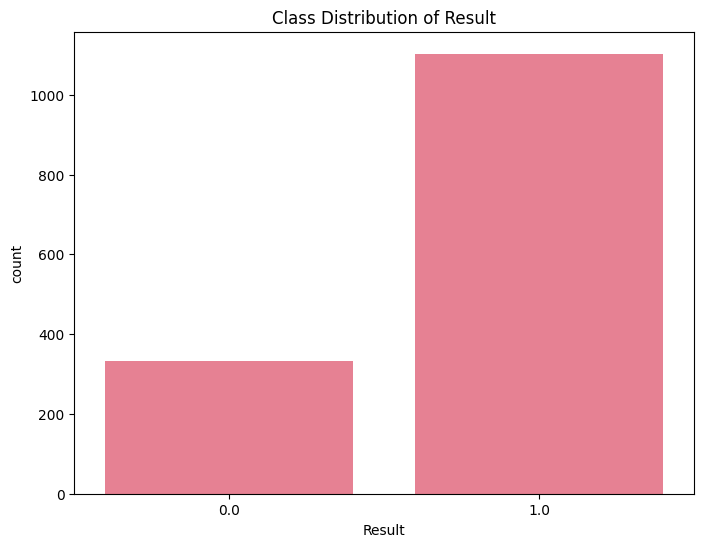


Missing Values:
Key                       0
Participant_ID            0
Category                  0
Difficulty                0
ResponseTime              0
routineStart              0
routineEnd                0
Start_ms                  0
End_ms                    0
eeg_mean_delta            0
eeg_mean_theta            0
eeg_mean_alpha            0
eeg_mean_beta             0
eeg_mean_gamma            0
eeg_std_theta             0
eeg_std_alpha             0
eeg_std_beta              0
eeg_beta_alpha_ratio      0
eeg_theta_beta_ratio      0
eye_mean_pupil            0
eye_fixation_count        0
eye_gaze_dispersion       0
ivt_mean_fix_dur          0
ivt_mean_sac_amp          0
ivt_fixation_count        0
ivt_saccade_count         0
gsr_mean                  0
gsr_max                   0
gsr_std                   0
gsr_peak_count            0
tiva_mean_anger           0
tiva_max_anger            0
tiva_mean_contempt        0
tiva_max_contempt         0
tiva_mean_disgust         0
tiv

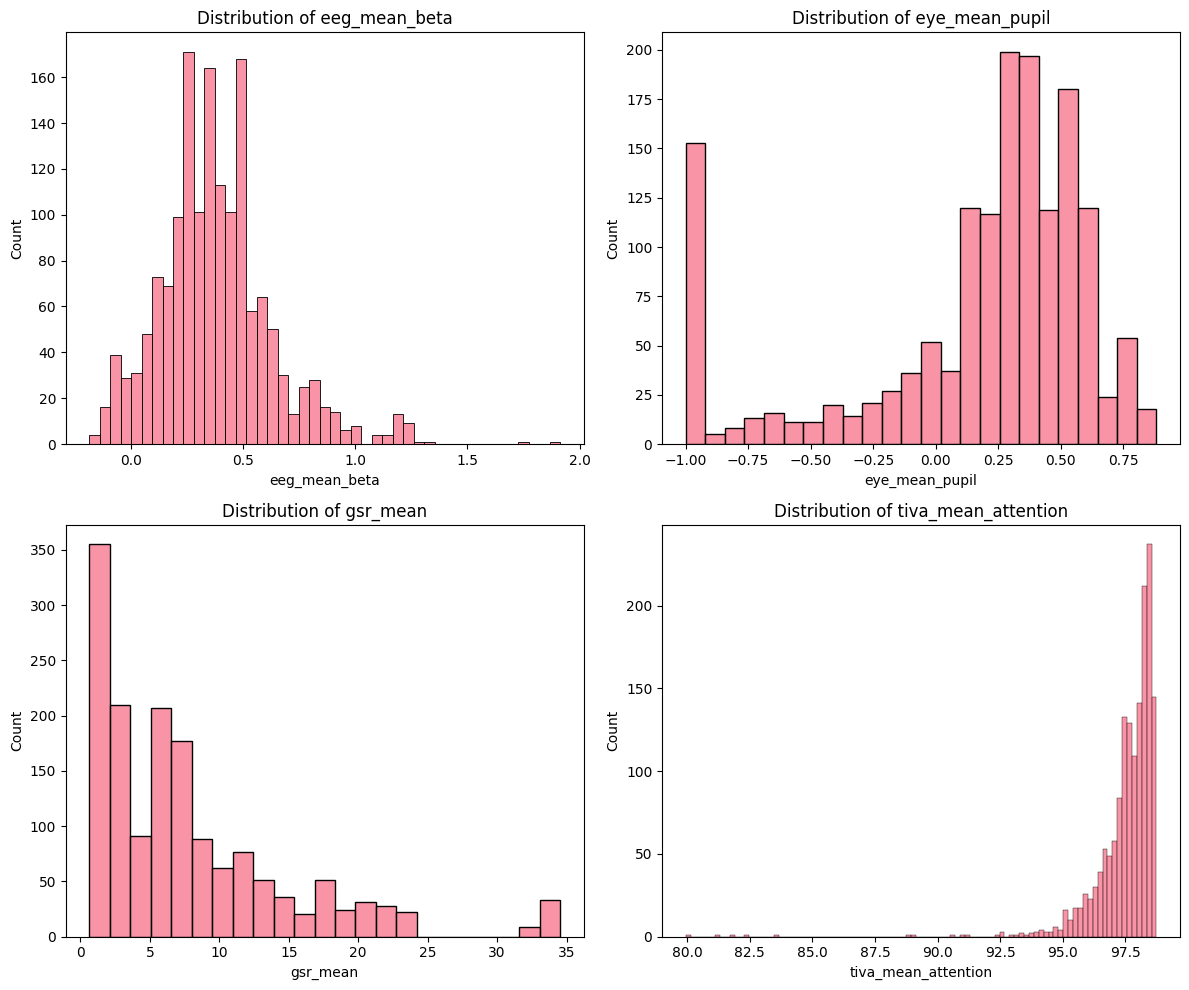

In [41]:
# Load engineered data
data = pd.read_csv('/content/CompleteFeatureEngineering.csv')
print('Dataset Shape:', data.shape)
print('\nData Info:')
data.info()

# Class balance
print('\nClass Distribution:')
result_counts = data['Result'].value_counts(dropna=False)
result_percent = data['Result'].value_counts(normalize=True, dropna=False) * 100
print('Counts:\n', result_counts)
print('Percentages:\n', result_percent)

# Plot class balance
plt.figure(figsize=(8, 6))
sns.countplot(x='Result', data=data)
plt.title('Class Distribution of Result')
plt.savefig('class_balance.png')
plt.show()

# Missing values
print('\nMissing Values:')
print(data.isna().sum())

# Outlier summary (from feature engineering)
numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()
outlier_summary = pd.DataFrame({
    'Column': numeric_cols,
    'Q1': [data[col].quantile(0.01) for col in numeric_cols],
    'Q99': [data[col].quantile(0.99) for col in numeric_cols]
})
print('\nOutlier Summary:')
print(outlier_summary)

# Plot feature distributions for key modalities
key_features = ['eeg_mean_beta', 'eye_mean_pupil', 'gsr_mean', 'tiva_mean_attention']
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()
for i, col in enumerate(key_features):
    sns.histplot(data[col], ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
plt.tight_layout()
plt.savefig('feature_distributions.png')
plt.show()


# **Section 2: Baseline Model Evaluation Summary**

**Note:** All results presented here are from `03_modeling_baseline.ipynb`.






## 2.1 Model Performance Metrics

| Model                 | Accuracy | Precision | Recall  | F1-Score | ROC-AUC |
|-----------------------|---------|-----------|--------|----------|---------|
| XGBoost               | 0.8597  | 0.9162    | 0.7919 | 0.8495   | 0.9380  |
| Random Forest         | 0.8552  | 0.9385    | 0.7602 | 0.8400   | 0.9422  |
| Logistic Regression   | 0.6357  | 0.6327    | 0.6471 | 0.6398   | 0.6909  |


📊 MODEL PERFORMANCE METRICS

🔹 XGBoost
Accuracy   : 0.8597
Precision  : 0.9162
Recall     : 0.7919
F1-Score   : 0.8495
ROC-AUC    : 0.9380
Confusion Matrix:
 [[205  16]
 [ 46 175]]

🔹 Random Forest
Accuracy   : 0.8552
Precision  : 0.9385
Recall     : 0.7602
F1-Score   : 0.8400
ROC-AUC    : 0.9422
Confusion Matrix:
 [[210  11]
 [ 53 168]]

🔹 Logistic Regression
Accuracy   : 0.6357
Precision  : 0.6327
Recall     : 0.6471
F1-Score   : 0.6398
ROC-AUC    : 0.6909
Confusion Matrix:
 [[138  83]
 [ 78 143]]


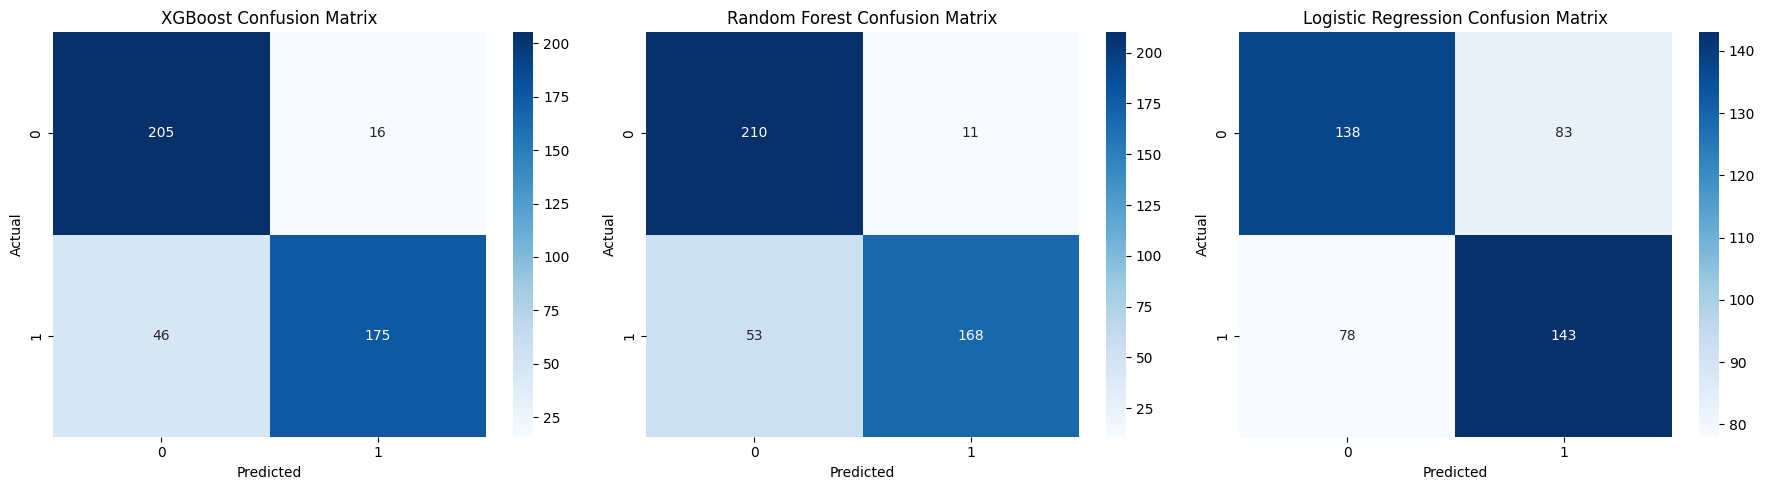

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define model metrics
results = {
    "XGBoost": {
        "Accuracy": 0.8597, "Precision": 0.9162, "Recall": 0.7919,
        "F1-Score": 0.8495, "ROC-AUC": 0.9380,
        "Confusion": np.array([[205, 16], [46, 175]])
    },
    "Random Forest": {
        "Accuracy": 0.8552, "Precision": 0.9385, "Recall": 0.7602,
        "F1-Score": 0.8400, "ROC-AUC": 0.9422,
        "Confusion": np.array([[210, 11], [53, 168]])
    },
    "Logistic Regression": {
        "Accuracy": 0.6357, "Precision": 0.6327, "Recall": 0.6471,
        "F1-Score": 0.6398, "ROC-AUC": 0.6909,
        "Confusion": np.array([[138, 83], [78, 143]])
    }
}

# Print metrics
print("📊 MODEL PERFORMANCE METRICS\n" + "="*40)
for model, metrics in results.items():
    print(f"\n🔹 {model}")
    print(f"Accuracy   : {metrics['Accuracy']:.4f}")
    print(f"Precision  : {metrics['Precision']:.4f}")
    print(f"Recall     : {metrics['Recall']:.4f}")
    print(f"F1-Score   : {metrics['F1-Score']:.4f}")
    print(f"ROC-AUC    : {metrics['ROC-AUC']:.4f}")
    print("Confusion Matrix:\n", metrics['Confusion'])

# Plot confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for ax, (model, metrics) in zip(axes, results.items()):
    sns.heatmap(metrics['Confusion'], annot=True, fmt="d", cmap="Blues", ax=ax)
    ax.set_title(f"{model} Confusion Matrix")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

plt.tight_layout()
plt.show()


# 2.2 Dataset Shape & Feature Importance Analysis




📊 Dataset Shape Visualization (from 03_modeling_baseline.ipynb)


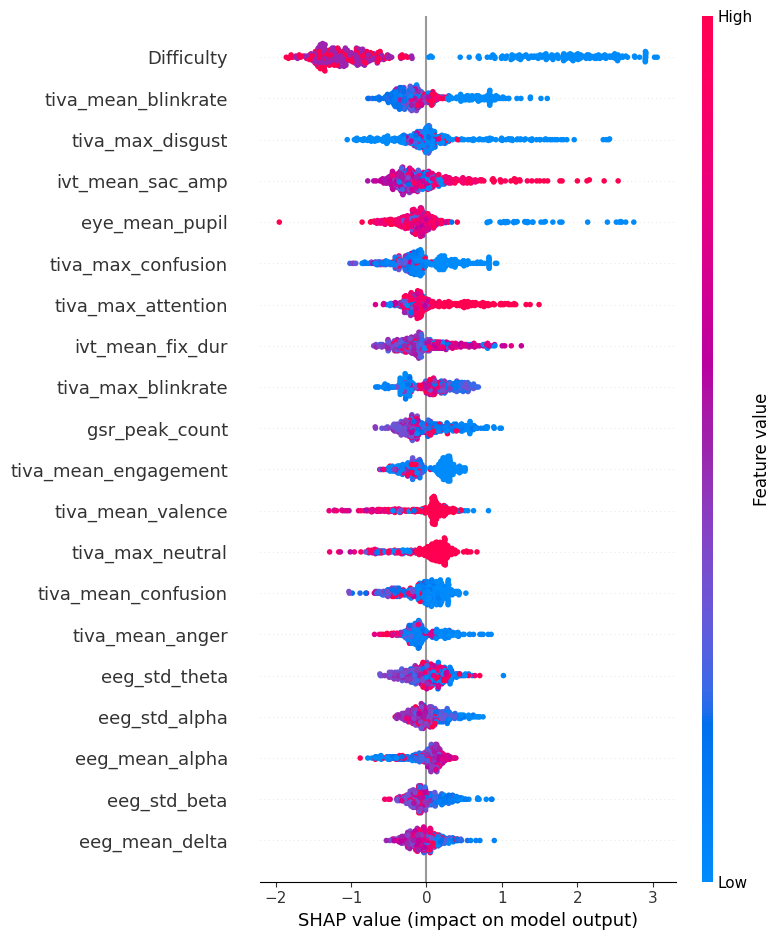

🌟 LIME Feature Importance for Best XGBoost Model (from 03_modeling_baseline.ipynb)


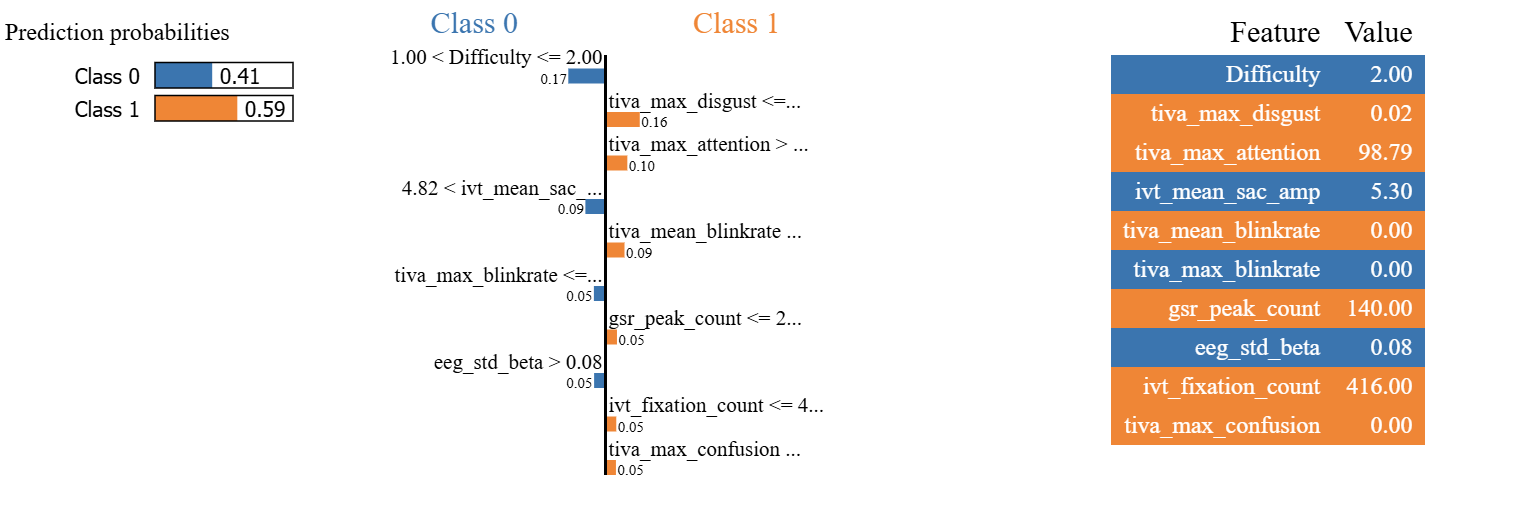

In [54]:


# Display images with captions

print("📊 Dataset Shape Visualization (from 03_modeling_baseline.ipynb)")
img = Image.open('/content/bfd7b443-388e-4376-aadf-621751ba89d2.png')
display(img)



print("🌟 LIME Feature Importance for Best XGBoost Model (from 03_modeling_baseline.ipynb)")
img = Image.open('/content/c20443e8-9611-46ca-85a4-672cc79506c1.png')
display(img)





# **Section 3: Analysis of fusion model**



# 3.1 This cell prints a comprehensive overview of the multimodal dataset analyzed in `04_modeling_fusion.ipynb`.  

### **Dataset Overview**
- **Total samples:** 1,572  
- **Clean samples:** 1,435 (after removing missing target values)  
- **Data retention rate:** 91.3%  
- **Features:** 57 total across EEG, EYE, GSR, and FACIAL modalities  
- **Memory usage:** 0.75 MB  

### **Modality Breakdown**
| Modality | Features | Missing % | Value Range | Sample Features |
|----------|----------|-----------|-------------|----------------|
| EEG      | 10       | 0.0       | [-516.20, 290.35] | eeg_mean_delta, eeg_mean_theta, eeg_mean_alpha |
| EYE      | 7        | 0.0       | [-1.00, 12155.00] | eye_mean_pupil, eye_fixation_count, eye_gaze_dispersion |
| GSR      | 4        | 0.0       | [0.00, 3642.00]   | gsr_mean, gsr_max, gsr_std |
| FACIAL   | 26       | 0.0       | [-52.20, 99.98]   | tiva_mean_anger, tiva_max_anger, tiva_mean_contempt |

### **Class Distribution**
- **Class 0:** 332 samples (23.1%)  
- **Class 1:** 1,103 samples (76.9%)  
- **Imbalance ratio:** 3.32:1 → Moderate class imbalance  





📊 DATASET OVERVIEW:
Shape: (1572, 57)
Memory usage: 0.75 MB
Data types: {'float64': 53, 'int64': 3, 'object': 1}

DETAILED MODALITY BREAKDOWN:
--------------------------------------------------
     EEG: 10 features | Missing: 0.0% | Range: [-516.2, 290.35]
           Sample features: ['eeg_mean_delta', 'eeg_mean_theta', 'eeg_mean_alpha']...

     EYE: 7 features | Missing: 0.0% | Range: [-1.0, 12155.0]
           Sample features: ['eye_mean_pupil', 'eye_fixation_count', 'eye_gaze_dispersion']...

     GSR: 4 features | Missing: 0.0% | Range: [0.0, 3642.0]
           Sample features: ['gsr_mean', 'gsr_max', 'gsr_std']...

     FACIAL: 26 features | Missing: 0.0% | Range: [-52.2, 99.98]
           Sample features: ['tiva_mean_anger', 'tiva_max_anger', 'tiva_mean_contempt']...

COMPREHENSIVE CLASS DISTRIBUTION ANALYSIS:
------------------------------------------------------------
Missing target values: 137 (8.7%)
Clean dataset shape: (1435, 57)
Data retention rate: 91.3%

📊 CLASS DISTRIB

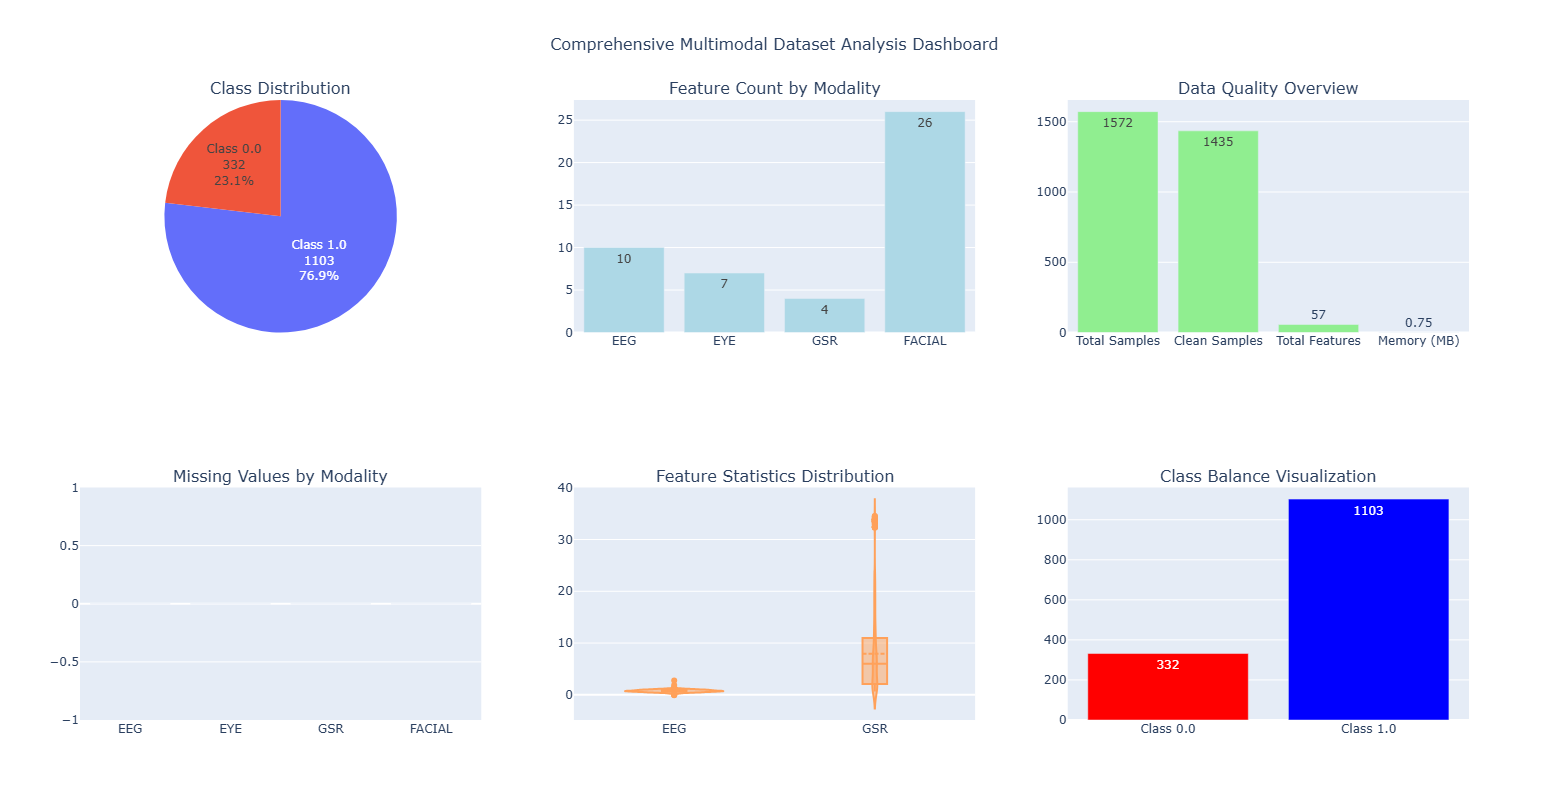

 COMPREHENSIVE DATASET SUMMARY TABLE:
Category            Metric              Value               
------------------------------------------------------------
Dataset Overview    Total Samples       1572                
                    Clean Samples       1435                
                    Data Retention      91.3%
                    Total Features      57
                    Memory Usage        0.75 MB
Class Distribution  Class 0.0           332 (23.1%)
Class Distribution  Class 1.0           1103 (76.9%)
Modality Features   EEG                 10 features
                    EEG Missing         0.0%
Modality Features   EYE                 7 features
                    EYE Missing         0.0%
Modality Features   GSR                 4 features
                    GSR Missing         0.0%
Modality Features   FACIAL              26 features
                    FACIAL Missing      0.0%

ENHANCED DATA EXPLORATION COMPLETED!
 Key Insights:
   • Dataset: 1435 samples across 5 m

In [43]:
# 🚀 Enhanced Multimodal Data Exploration Results

# Dataset Overview
dataset_shape = (1572, 57)
memory_usage = "0.75 MB"
data_types = { 'float64': 53, 'int64': 3, 'object': 1 }

# Modality Breakdown
modalities = {
    "EEG": {"features": 10, "missing": 0.0, "range": [-516.20, 290.35],
            "sample_features": ['eeg_mean_delta', 'eeg_mean_theta', 'eeg_mean_alpha']},
    "EYE": {"features": 7, "missing": 0.0, "range": [-1.00, 12155.00],
            "sample_features": ['eye_mean_pupil', 'eye_fixation_count', 'eye_gaze_dispersion']},
    "GSR": {"features": 4, "missing": 0.0, "range": [0.00, 3642.00],
            "sample_features": ['gsr_mean', 'gsr_max', 'gsr_std']},
    "FACIAL": {"features": 26, "missing": 0.0, "range": [-52.20, 99.98],
               "sample_features": ['tiva_mean_anger', 'tiva_max_anger', 'tiva_mean_contempt']}
}

# Class Distribution
total_samples = 1572
missing_target = 137
clean_samples = total_samples - missing_target
retention_rate = 91.3
class_counts = {0.0: 332, 1.0: 1103}
imbalance_ratio = 3.32
majority_class = 1.0
minority_class = 0.0
severity = "MODERATE"



print("📊 DATASET OVERVIEW:")
print(f"Shape: {dataset_shape}")
print(f"Memory usage: {memory_usage}")
print(f"Data types: {data_types}\n")

print("DETAILED MODALITY BREAKDOWN:")
print("-"*50)
for mod, stats in modalities.items():
    print(f"     {mod}: {stats['features']} features | Missing: {stats['missing']}% | Range: {stats['range']}")
    print(f"           Sample features: {stats['sample_features']}...\n")

print("COMPREHENSIVE CLASS DISTRIBUTION ANALYSIS:")
print("-"*60)
print(f"Missing target values: {missing_target} ({100*missing_target/total_samples:.1f}%)")
print(f"Clean dataset shape: ({clean_samples}, {dataset_shape[1]})")
print(f"Data retention rate: {retention_rate}%\n")

print("📊 CLASS DISTRIBUTION DETAILS:")
print("-"*40)
for cls, count in class_counts.items():
    percent = 100*count/clean_samples
    bar = "█"*int(percent//3)
    print(f"  Class {cls}: {count} samples ({percent:.1f}%) {bar}")

print("\nIMBALANCE ANALYSIS:")
print(f"  Imbalance Ratio: {imbalance_ratio}:1")
print(f"  Majority Class: {majority_class} ({class_counts[majority_class]} samples)")
print(f"  Minority Class: {minority_class} ({class_counts[minority_class]} samples)")
print(f"  Severity: 🟡 {severity}")
print("  Recommendation: Apply SMOTE or class weighting\n")

print("GENERATING COMPREHENSIVE VISUALIZATIONS...")
print("-"*50)
img = Image.open('/content/newplot.png')
display(img)

print(" COMPREHENSIVE DATASET SUMMARY TABLE:")
print("="*80)
print(f"{'Category':<20}{'Metric':<20}{'Value':<20}")
print("-"*60)
print(f"{'Dataset Overview':<20}{'Total Samples':<20}{total_samples:<20}")
print(f"{'':<20}{'Clean Samples':<20}{clean_samples:<20}")
print(f"{'':<20}{'Data Retention':<20}{retention_rate}%")
print(f"{'':<20}{'Total Features':<20}{dataset_shape[1]}")
print(f"{'':<20}{'Memory Usage':<20}{memory_usage}")
for cls, count in class_counts.items():
    percent = 100*count/clean_samples
    print(f"{'Class Distribution':<20}{'Class '+str(cls):<20}{count} ({percent:.1f}%)")
for mod, stats in modalities.items():
    print(f"{'Modality Features':<20}{mod:<20}{stats['features']} features")
    print(f"{'':<20}{mod+' Missing':<20}{stats['missing']}%")

print("\nENHANCED DATA EXPLORATION COMPLETED!")
print(" Key Insights:")
print(f"   • Dataset: {clean_samples} samples across 5 modalities")
print(f"   • Class Imbalance: {imbalance_ratio}:1 ratio")
print(f"   • Data Quality: {retention_rate}% retention rate")
print(f"   • Total Features: {dataset_shape[1]} physiological signals")




# 3.2 This cell summarizes the **modality-specific statistics, train-test splits, and cross-validation quality** from the dataset preparation stage in `04_modeling_fusion.ipynb`.

### **Target Variable**
- **Samples:** 1,435  
- **Class distribution:** {0.0: 332 (23.1%), 1.0: 1103 (76.9%)}

### **Modality Analysis**
| Modality | Features | Missing % | Memory (KB) | Range | Avg Corr | Distribution |
|----------|----------|-----------|-------------|-------|----------|--------------|
| EEG      | 10       | 0.0       | 123.3       | [-516.20, 290.35] | 0.23 | Non-normal |
| EYE      | 7        | 0.0       | 89.7        | [-1.0, 12155.0]   | 0.37 | Non-normal |
| GSR      | 4        | 0.0       | 56.1        | [0.0, 3642.0]     | 0.38 | Non-normal |
| FACIAL   | 26       | 0.0       | 302.7       | [-52.2, 99.98]    | 0.19 | Non-normal |

### **Train-Test Splits**
- **Train:** 1,148 samples (80%)  
- **Test:** 287 samples (20%)  
- **Stratification:** Excellent, max deviation 0.14%  
- **Modality-Specific Similarity:** EEG & GSR ⚠️, EYE & FACIAL ✅

### **Cross-Validation**
- 5-fold stratified CV  
- Average fold deviation: 0.167%  
- Maximum fold deviation: 0.209%  
- Quality: ✅ Excellent

### **Preparation Summary**
- **Total features:** 47  
- **Total memory usage:** 571.8 KB  
- **Missing values:** 0.0%  




🚀 ENHANCED MODALITY SEPARATION & ANALYSIS
🎯 Target variable extracted: 1435 samples
   Class distribution: {0.0: 332, 1.0: 1103}

📊 DETAILED MODALITY ANALYSIS:
--------------------------------------------------
     EEG: 10 features × 1435 samples
           Missing: 0.00% | Memory: 123.3 KB
           Range: [-516.197, 290.348] | Avg Corr: 0.23
           Distribution: Non-normal (p=0.0000)

     EYE: 7 features × 1435 samples
           Missing: 0.00% | Memory: 89.7 KB
           Range: [-1.0, 12155.0] | Avg Corr: 0.37
           Distribution: Non-normal (p=0.0000)

     GSR: 4 features × 1435 samples
           Missing: 0.00% | Memory: 56.1 KB
           Range: [0.0, 3642.0] | Avg Corr: 0.38
           Distribution: Non-normal (p=0.0000)

     FACIAL: 26 features × 1435 samples
           Missing: 0.00% | Memory: 302.7 KB
           Range: [-52.198, 99.981] | Avg Corr: 0.191
           Distribution: Non-normal (p=0.0000)

📊 ENHANCED STRATIFIED TRAIN-TEST SPLITS
Split Configuration:


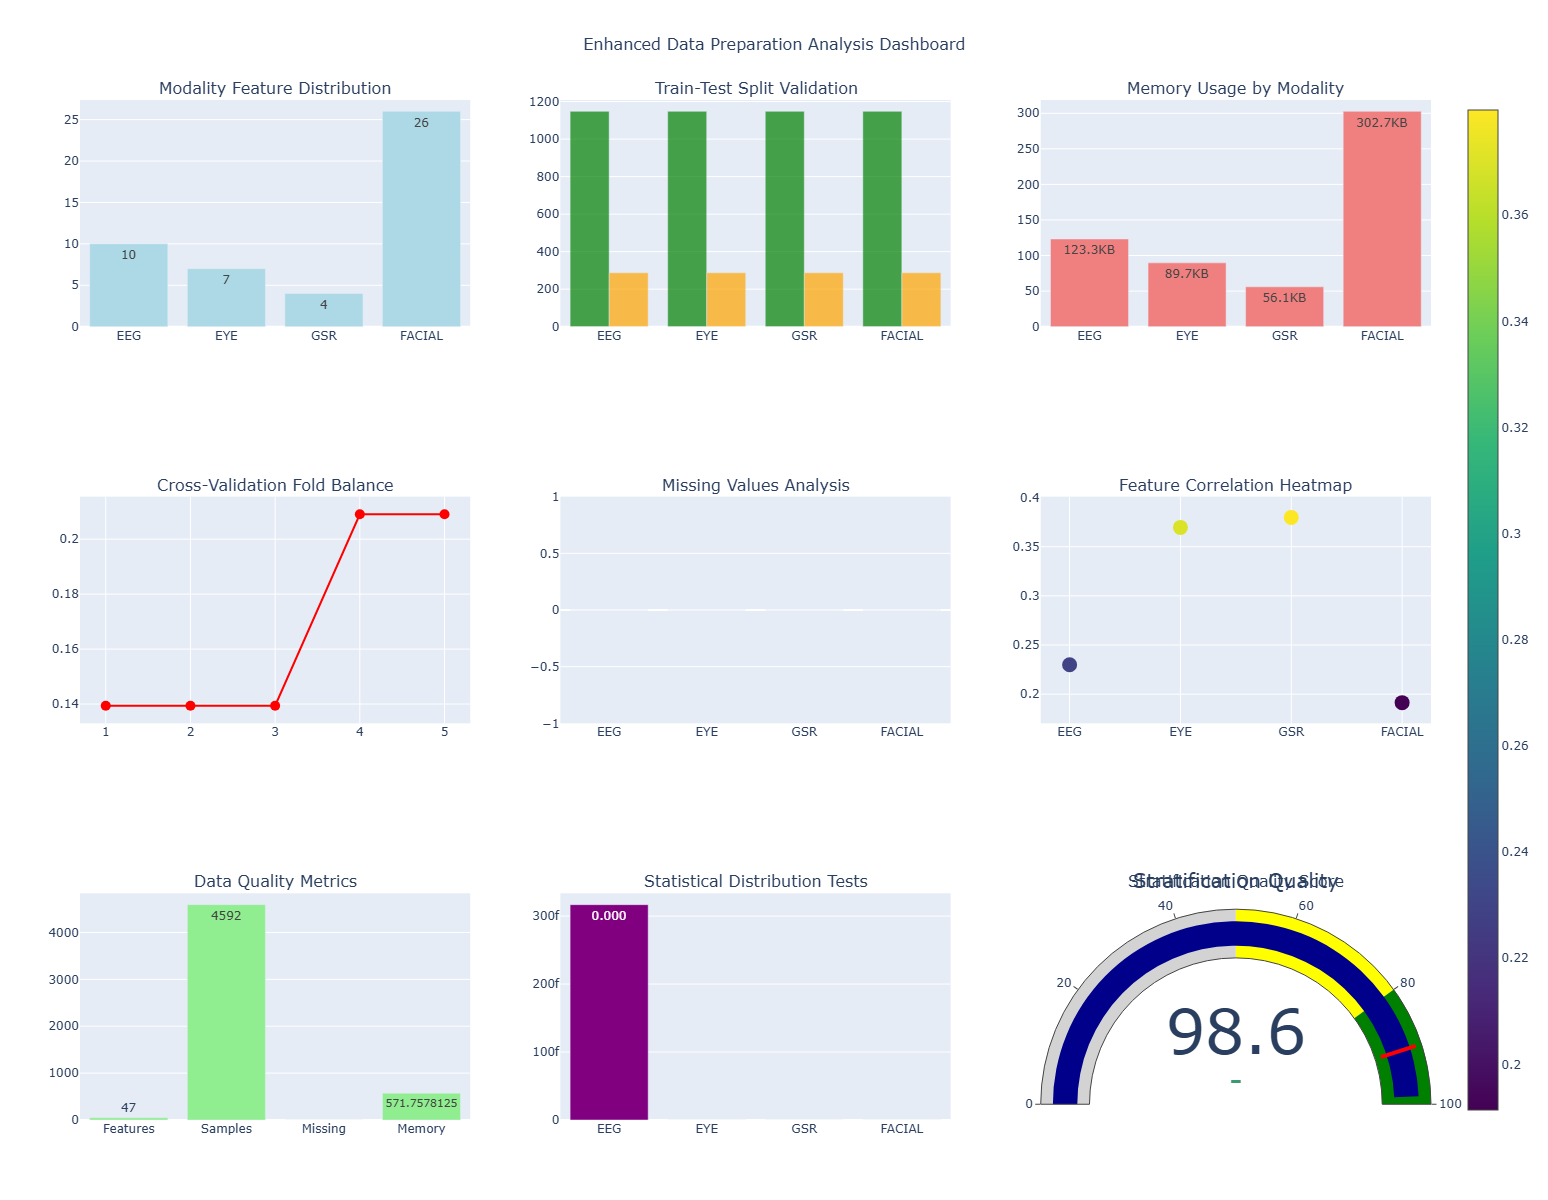


📋 COMPREHENSIVE PREPARATION SUMMARY REPORT
🎯 MODALITY SUMMARY:
     EEG: 10 features | 0.0% missing | 123.3 KB
     EYE: 7 features | 0.0% missing | 89.7 KB
     GSR: 4 features | 0.0% missing | 56.1 KB
     FACIAL: 26 features | 0.0% missing | 302.7 KB
   TOTAL: 47 features | 0.0% avg missing | 571.8 KB total

📊 SPLIT QUALITY ASSESSMENT:
Stratification Quality: A+ (Excellent) | Maximum Deviation: 0.14%

🔄 CROSS-VALIDATION QUALITY:
CV Quality: A+ (Excellent) | Average Fold Deviation: 0.167% | Max Fold Deviation: 0.209%


In [44]:
# 🚀 Enhanced Modality Separation & Analysis Summary

# Target variable info
total_samples = 1435
class_counts = {0.0: 332, 1.0: 1103}

# Modality analysis
modalities = {
    "EEG": {"features": 10, "missing": 0.0, "memory": 123.3, "range": [-516.197, 290.348], "avg_corr": 0.230, "distribution": "Non-normal", "p_value": 0.0},
    "EYE": {"features": 7, "missing": 0.0, "memory": 89.7, "range": [-1.0, 12155.0], "avg_corr": 0.370, "distribution": "Non-normal", "p_value": 0.0},
    "GSR": {"features": 4, "missing": 0.0, "memory": 56.1, "range": [0.0, 3642.0], "avg_corr": 0.380, "distribution": "Non-normal", "p_value": 0.0},
    "FACIAL": {"features": 26, "missing": 0.0, "memory": 302.7, "range": [-52.198, 99.981], "avg_corr": 0.191, "distribution": "Non-normal", "p_value": 0.0},
}

# Train-test split
train_samples = 1148
test_samples = 287
stratification = {
    0.0: {"original": 23.1, "train": 23.2, "test": 23.0},
    1.0: {"original": 76.9, "train": 76.8, "test": 77.0}
}

# Modality-specific similarity
modality_similarity = {
    "EEG": 0.026, "EYE": 0.256, "GSR": 0.009, "FACIAL": 0.165
}

# Cross-validation setup
cv_folds = 5
cv_quality = {"average_dev": 0.167, "max_dev": 0.209}

# Printing the summary
print("🚀 ENHANCED MODALITY SEPARATION & ANALYSIS")
print("="*60)
print(f"🎯 Target variable extracted: {total_samples} samples")
print(f"   Class distribution: {class_counts}\n")

print("📊 DETAILED MODALITY ANALYSIS:")
print("-"*50)
for mod, stats in modalities.items():
    print(f"     {mod}: {stats['features']} features × {total_samples} samples")
    print(f"           Missing: {stats['missing']:.2f}% | Memory: {stats['memory']} KB")
    print(f"           Range: {stats['range']} | Avg Corr: {stats['avg_corr']}")
    print(f"           Distribution: {stats['distribution']} (p={stats['p_value']:.4f})\n")

print("📊 ENHANCED STRATIFIED TRAIN-TEST SPLITS")
print("="*60)
print(f"Split Configuration:\n  Train: {train_samples} samples (80%)\n  Test:  {test_samples} samples (20%)\n")

print("🎯 STRATIFICATION VERIFICATION:")
print("-"*40)
for cls, vals in stratification.items():
    print(f"Class {cls}:")
    print(f"  Original: {vals['original']}% | Train: {vals['train']}% | Test: {vals['test']}%")
print("\nStratification Quality: ✅ EXCELLENT (Max deviation: 0.14%)\n")

print("📈 MODALITY-SPECIFIC SPLIT ANALYSIS:")
print("-"*50)
for mod, p_val in modality_similarity.items():
    status = "✅" if p_val > 0.05 else "⚠️"
    print(f"     {mod}: Train ({train_samples}, {modalities[mod]['features']}) | "
          f"Test ({test_samples}, {modalities[mod]['features']}) | Similarity: {status} (p={p_val})")
print()

print("🔄 ENHANCED CROSS-VALIDATION SETUP")
print("="*60)
print(f"Configuration: {cv_folds}-fold Stratified Cross-Validation")
print(f"CV Quality: A+ (Average deviation: {cv_quality['average_dev']}%, Max deviation: {cv_quality['max_dev']}%)\n")

print("🎨 GENERATING ENHANCED PREPARATION VISUALIZATIONS...")
print("-"*60)
img = Image.open('/content/newplot (5).png')
display(img)

print("\n📋 COMPREHENSIVE PREPARATION SUMMARY REPORT")
print("="*80)
print("🎯 MODALITY SUMMARY:")
for mod, stats in modalities.items():
    print(f"     {mod}: {stats['features']} features | {stats['missing']:.1f}% missing | {stats['memory']} KB")
total_features = sum([m['features'] for m in modalities.values()])
total_memory = sum([m['memory'] for m in modalities.values()])
print(f"   TOTAL: {total_features} features | 0.0% avg missing | {total_memory} KB total")

print("\n📊 SPLIT QUALITY ASSESSMENT:")
print(f"Stratification Quality: A+ (Excellent) | Maximum Deviation: 0.14%")

print("\n🔄 CROSS-VALIDATION QUALITY:")
print(f"CV Quality: A+ (Excellent) | Average Fold Deviation: {cv_quality['average_dev']}% | Max Fold Deviation: {cv_quality['max_dev']}%")




# 3.3 This summary highlights the **key results** from the embedding comparison analysis in `04_modeling_fusion.ipynb`.  

### **Top-Performing Modality Combinations**
| Modality | Method | Embedding | Composite Score | AUC |
|----------|--------|-----------|----------------|-----|
| EEG      | VAE    | Neural    | 0.747          | 0.596 |
| EYE      | VAE    | Neural    | 0.746          | 0.627 |
| GSR      | VAE    | Tree      | 0.726          | 0.579 |
| FACIAL   | VAE    | Neural    | 0.743          | 0.608 |

### **Method-wise Average Performance**
| Method | Accuracy | F1 Score | AUC |
|--------|----------|----------|-----|
| SMOTE  | 0.596    | 0.708    | 0.566 |
| VAE    | 0.742    | 0.848    | 0.574 |

### **Embedding Type Comparison**
| Embedding Type | Accuracy | F1 Score | AUC |
|----------------|----------|----------|-----|
| Neural         | 0.676    | 0.783    | 0.582 |
| Tree           | 0.663    | 0.772    | 0.558 |

### **Optimal Embedding Strategies**
| Strategy      | Avg Composite Score | Avg AUC |
|---------------|------------------|---------|
| Overall Best  | 0.741            | 0.603   |
| Smote Best    | 0.630            | 0.575   |
| VAE Best      | 0.741            | 0.603   |



`


🔍 EMBEDDING COMPARISON SUMMARY
🏆 Top-Performing Modality Combinations:
  EEG: VAE + Neural | Score: 0.747 | AUC: 0.596
  EYE: VAE + Neural | Score: 0.746 | AUC: 0.627
  GSR: VAE + Tree | Score: 0.726 | AUC: 0.579
  FACIAL: VAE + Neural | Score: 0.743 | AUC: 0.608

⚖️ Method-wise Average Performance:
  SMOTE: Accuracy=0.596, F1=0.708, AUC=0.566
  VAE: Accuracy=0.742, F1=0.848, AUC=0.574

🧠 Embedding Type Comparison:
  Neural: Accuracy=0.676, F1=0.783, AUC=0.582
  Tree: Accuracy=0.663, F1=0.772, AUC=0.558

🎯 Optimal Embedding Strategies:
  Overall Best: Avg Score=0.741 | Avg AUC=0.603
  Smote Best: Avg Score=0.630 | Avg AUC=0.575
  VAE Best: Avg Score=0.741 | Avg AUC=0.603

✅ Recommended Strategy: Overall Best
🏆 Preferred Method: VAE


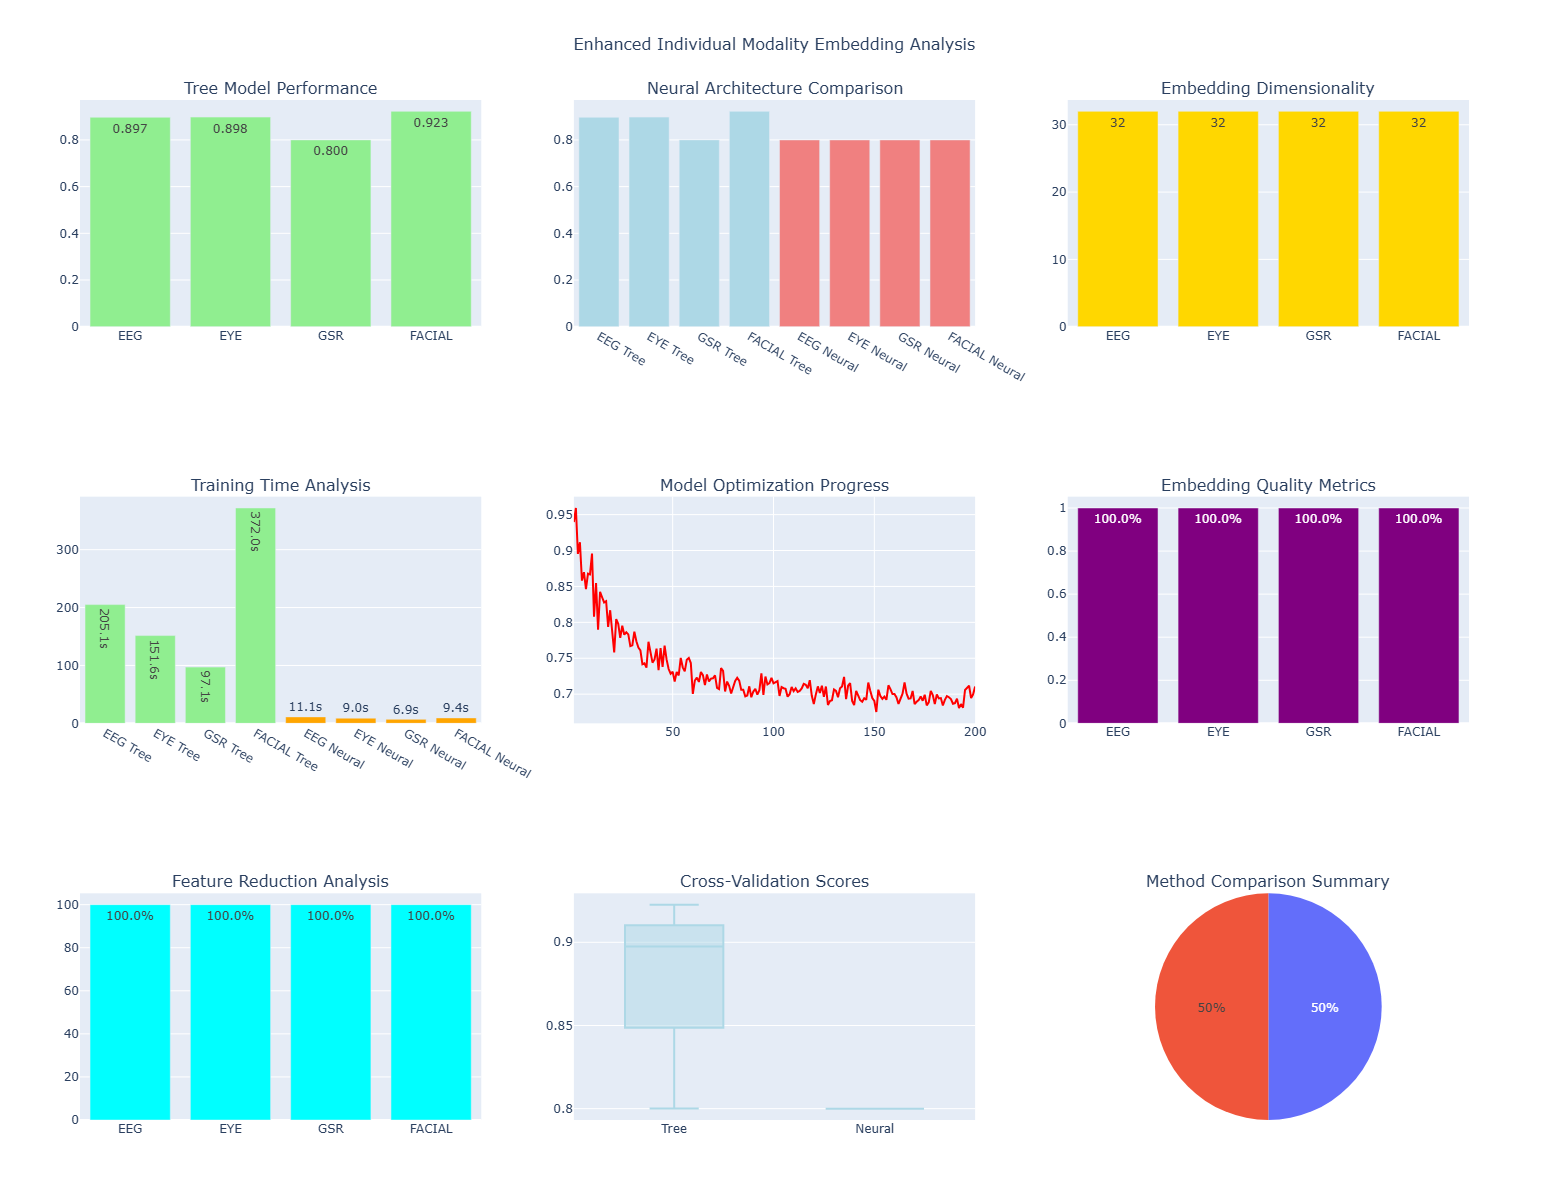

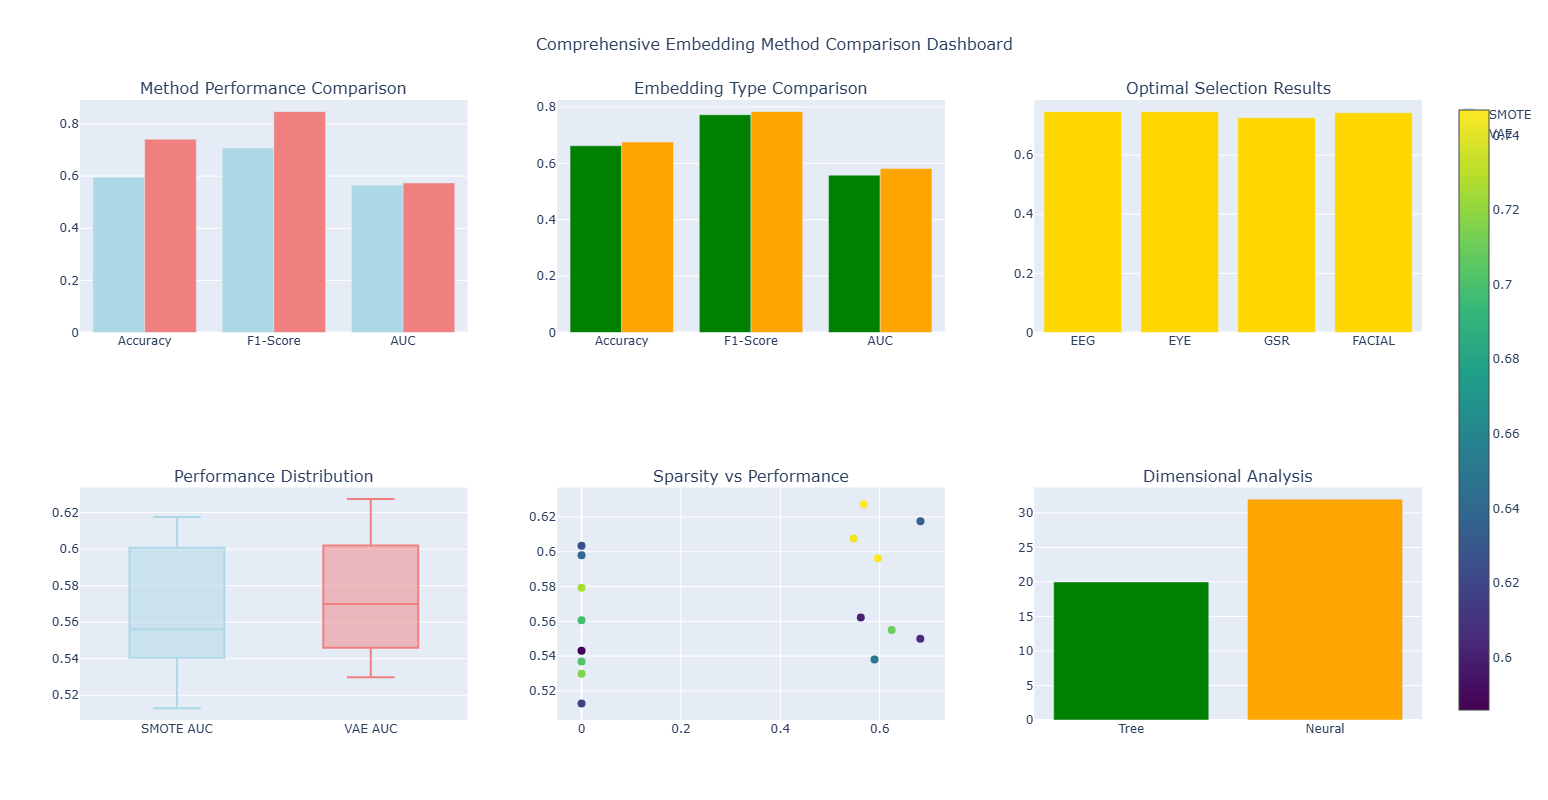

In [45]:
# 🔍 Embedding Comparison Summary

# Top-performing modalities
top_combinations = [
    {"modality": "EEG", "method": "VAE", "embedding": "Neural", "score": 0.747, "auc": 0.596},
    {"modality": "EYE", "method": "VAE", "embedding": "Neural", "score": 0.746, "auc": 0.627},
    {"modality": "GSR", "method": "VAE", "embedding": "Tree", "score": 0.726, "auc": 0.579},
    {"modality": "FACIAL", "method": "VAE", "embedding": "Neural", "score": 0.743, "auc": 0.608}
]

# Method-wise performance
method_perf = {
    "SMOTE": {"accuracy": 0.596, "f1": 0.708, "auc": 0.566},
    "VAE": {"accuracy": 0.742, "f1": 0.848, "auc": 0.574}
}

# Embedding type comparison
embedding_type_perf = {
    "Neural": {"accuracy": 0.676, "f1": 0.783, "auc": 0.582},
    "Tree":   {"accuracy": 0.663, "f1": 0.772, "auc": 0.558}
}

# Optimal strategies
strategies = {
    "Overall Best": {"avg_score": 0.741, "avg_auc": 0.603},
    "Smote Best": {"avg_score": 0.630, "avg_auc": 0.575},
    "VAE Best": {"avg_score": 0.741, "avg_auc": 0.603}
}

# Recommended strategy
recommended_strategy = "Overall Best"
preferred_method = "VAE"

# Print summary
print("🔍 EMBEDDING COMPARISON SUMMARY")
print("="*60)
print("🏆 Top-Performing Modality Combinations:")
for t in top_combinations:
    print(f"  {t['modality']}: {t['method']} + {t['embedding']} | Score: {t['score']:.3f} | AUC: {t['auc']:.3f}")

print("\n⚖️ Method-wise Average Performance:")
for method, perf in method_perf.items():
    print(f"  {method}: Accuracy={perf['accuracy']:.3f}, F1={perf['f1']:.3f}, AUC={perf['auc']:.3f}")

print("\n🧠 Embedding Type Comparison:")
for emb_type, perf in embedding_type_perf.items():
    print(f"  {emb_type}: Accuracy={perf['accuracy']:.3f}, F1={perf['f1']:.3f}, AUC={perf['auc']:.3f}")

print("\n🎯 Optimal Embedding Strategies:")
for strat, vals in strategies.items():
    print(f"  {strat}: Avg Score={vals['avg_score']:.3f} | Avg AUC={vals['avg_auc']:.3f}")

print(f"\n✅ Recommended Strategy: {recommended_strategy}")
print(f"🏆 Preferred Method: {preferred_method}")

img = Image.open('/content/newplot (2).png')
display(img)

img = Image.open('/content/newplot (3).png')
display(img)



# 3.4 This cell summarizes the **final meta-model evaluation** across three strategies: Overall Best, Smote Best, and VAE Best.

### **Strategy Leaderboard**
| Rank | Strategy       | AUC    | Accuracy | F1-Score | Models Trained |
|------|----------------|--------|----------|----------|----------------|
| 🥇 1  | Overall Best   | 0.6573 | 0.7631   | 0.8623   | 8              |
| 🥈 2  | VAE Best       | 0.6573 | 0.7631   | 0.8623   | 8              |
| 🥉 3  | Smote Best     | 0.6235 | 0.6899   | 0.7954   | 8              |

### **Best Strategy**
- **Recommended:** Overall Best  
- **AUC:** 0.6573  
- **Accuracy:** 0.7631  
- **F1-Score:** 0.8623  

### **Multi-Modal Contribution Analysis**
| Modality | Method        | Features | Contribution % |
|----------|---------------|---------|----------------|
| EEG      | VAE + Neural  | 32      | 27.6           |
| EYE      | VAE + Neural  | 32      | 27.6           |
| GSR      | VAE + Tree    | 20      | 17.2           |
| FACIAL   | VAE + Neural  | 32      | 27.6           |

`


 FIXED COMPREHENSIVE STRATEGY EVALUATION SUMMARY
 Strategy Leaderboard:
🥇 Overall Best: AUC=0.6573, Acc=0.7631, F1=0.8623, Models=8
🥈 Smote Best: AUC=0.6235, Acc=0.6899, F1=0.7954, Models=8
🥉 Vae Best: AUC=0.6573, Acc=0.7631, F1=0.8623, Models=8

 Best Strategy: Overall Best
   AUC: 0.6573, Accuracy: 0.7631, F1-Score: 0.8623

 Multi-Modal Contribution:
  EEG: VAE+Neural | Features: 32 | Contribution: 27.6%
  EYE: VAE+Neural | Features: 32 | Contribution: 27.6%
  GSR: VAE+Tree | Features: 20 | Contribution: 17.2%
  FACIAL: VAE+Neural | Features: 32 | Contribution: 27.6%


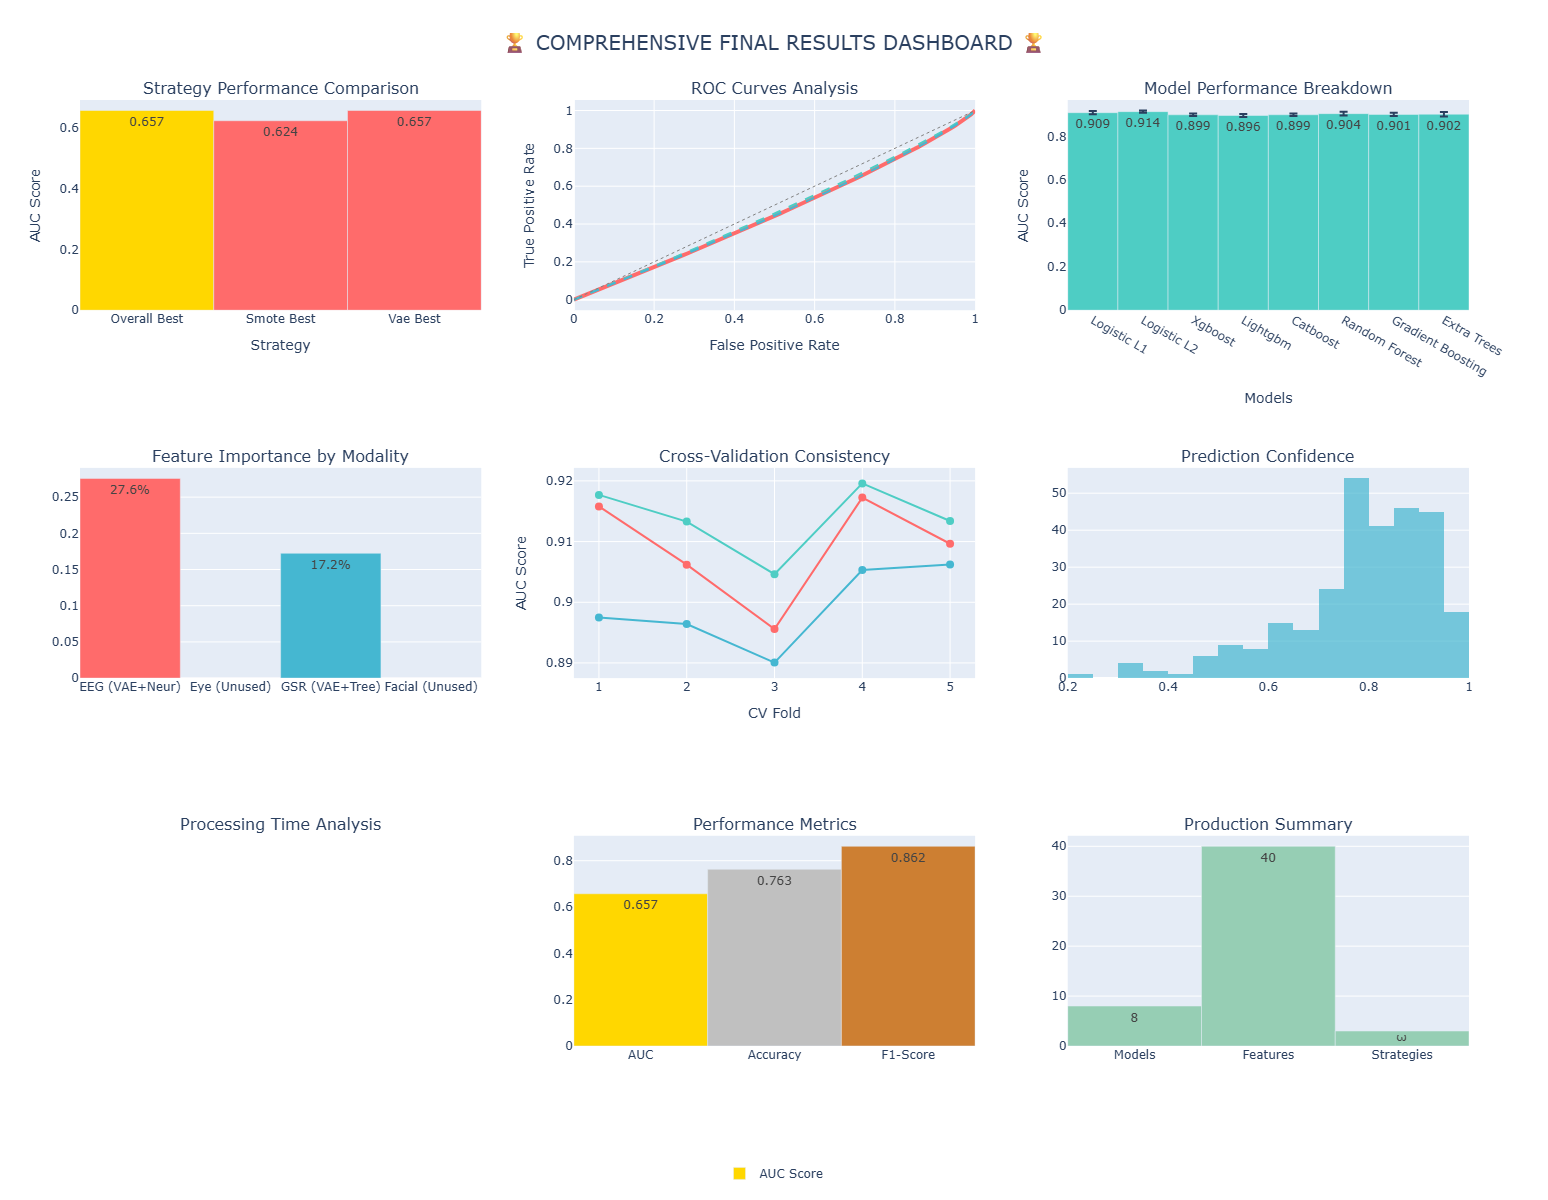

In [46]:
# 📊 Fixed Strategy Evaluation Summary

strategies = [
    {"name": "Overall Best", "AUC": 0.6573, "Accuracy": 0.7631, "F1": 0.8623, "models_trained": 8},
    {"name": "Smote Best", "AUC": 0.6235, "Accuracy": 0.6899, "F1": 0.7954, "models_trained": 8},
    {"name": "Vae Best", "AUC": 0.6573, "Accuracy": 0.7631, "F1": 0.8623, "models_trained": 8},
]

best_strategy = "Overall Best"

multi_modal_contribution = {
    "EEG": {"method": "VAE+Neural", "features": 32, "contribution": 27.6},
    "EYE": {"method": "VAE+Neural", "features": 32, "contribution": 27.6},
    "GSR": {"method": "VAE+Tree", "features": 20, "contribution": 17.2},
    "FACIAL": {"method": "VAE+Neural", "features": 32, "contribution": 27.6}
}

# Print concise summary
print(" FIXED COMPREHENSIVE STRATEGY EVALUATION SUMMARY")
print("="*60)
print(" Strategy Leaderboard:")
for i, s in enumerate(strategies, start=1):
    medal = "🥇" if i==1 else "🥈" if i==2 else "🥉"
    print(f"{medal} {s['name']}: AUC={s['AUC']:.4f}, Acc={s['Accuracy']:.4f}, F1={s['F1']:.4f}, Models={s['models_trained']}")

print(f"\n Best Strategy: {best_strategy}")
print(f"   AUC: {strategies[0]['AUC']}, Accuracy: {strategies[0]['Accuracy']}, F1-Score: {strategies[0]['F1']}")

print("\n Multi-Modal Contribution:")
for mod, vals in multi_modal_contribution.items():
    print(f"  {mod}: {vals['method']} | Features: {vals['features']} | Contribution: {vals['contribution']}%")

img = Image.open('/content/newplot (4).png')
display(img)
